## Conventional First Lien Application Approval Prediction

#### The purpose of this project is to predict the underwriting decision for Conventional First Lien loans in Tuscon,Arizona.
The dataset for this project can be downloaded from the link below

https://ffiec.cfpb.gov/data-browser/data/2020?category=msamds&items=46060&actions_taken=1,2,3

For this model we will be performing the following steps in a mixed order.
1. Exploratory Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Creation
5. Model Refining
6. Results Analysis
7. Exporting the Results
      

### Importing Necessary Packages

In [1]:
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.pandas.set_option("display.max_columns", None)
from datetime import datetime
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

import warnings
warnings.filterwarnings('ignore')

start_time = time.time()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Importing Data

In [2]:
dataset = pd.read_csv('msamd_46060_actions_taken_1-2-3.csv')
dataset.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2020,254900CYWJYH3ES8BV63,46060,AZ,4019.0,4.019005e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,White,Joint,1,6,2,1,31,1,1111,1111,1111,485000.0,Exempt,Exempt,Exempt,2,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,1111,1111,1111,1111,Exempt,1,1,1111,1111,1,Exempt,100.0,Exempt,1111,1111,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3,3,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,45-54,45-54,No,No,1111,1111,1111,NaN,NaN,NaN,NaN,1111,NaN,NaN,NaN,3203,10.52,68400,180,1269,1613,18
1,2020,5493004K0Z4RFJSPYT52,46060,AZ,4019.0,4.019004e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Joint,Joint,2,0,2,1,31,1,2,2,2,245000.0,67.11,3.125,0.204,3,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,2,2,2,2,365000,1,1,3,5,1,NaN,118.0,30%-<36%,1,9,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,2.0,23.0,NaN,NaN,NaN,2,2,1,2,2,2,35-44,35-44,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,2726,44.90,68400,96,466,680,13
2,2020,549300PZ44DNQDPOV865,46060,AZ,4019.0,4.019004e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,Race Not Available,Male,1,0,2,1,31,1,2,2,2,155000.0,75,3.25,0.696,3,1949.69,NaN,1010,NaN,NaN,240,NaN,NaN,2,2,2,2,205000,1,3,3,5,1,NaN,148.0,49,1,10,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,6.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,1,5,2,4,45-54,9999,No,NaN,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,8735,77.85,68400,105,2201,2995,12
3,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019005e+09,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Joint,3,0,2,3,31,1,2,2,2,245000.0,104.979,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,2,2,2,2,235000,1,1,3,5,1,NaN,0.0,NaN,1,1,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,45-54,45-54,No,No,2,3,6,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,6471,32.28,68400,109,1727,2354,27
4,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019005e+09,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not A

In [3]:
dataset.shape

(69360, 99)

We have a total of 69,360 observations and 99 features in the data.

### Data Analysis and Feature Engineering

#### Reducing the dataset Conventional: First Lien Loans
Currently the dataset provided is filled with all products, but this this project is only to predict conventional first lien loans. So will now pull only those records which are Conventional First Lien.

In [4]:
df = dataset.loc[dataset['derived_loan_product_type'] == 'Conventional:First Lien',:]
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2020,254900CYWJYH3ES8BV63,46060,AZ,4019.0,4.019005e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,White,Joint,1,6,2,1,31,1,1111,1111,1111,485000.0,Exempt,Exempt,Exempt,2,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,Exempt,1111,1111,1111,1111,Exempt,1,1,1111,1111,1,Exempt,100.0,Exempt,1111,1111,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3,3,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,45-54,45-54,No,No,1111,1111,1111,NaN,NaN,NaN,NaN,1111,NaN,NaN,NaN,3203,10.52,68400,180,1269,1613,18
1,2020,5493004K0Z4RFJSPYT52,46060,AZ,4019.0,4.019004e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Joint,Joint,2,0,2,1,31,1,2,2,2,245000.0,67.11,3.125,0.204,3,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,2,2,2,2,365000,1,1,3,5,1,NaN,118.0,30%-<36%,1,9,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,2.0,23.0,NaN,NaN,NaN,2,2,1,2,2,2,35-44,35-44,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,2726,44.90,68400,96,466,680,13
2,2020,549300PZ44DNQDPOV865,46060,AZ,4019.0,4.019004e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,Race Not Available,Male,1,0,2,1,31,1,2,2,2,155000.0,75,3.25,0.696,3,1949.69,NaN,1010,NaN,NaN,240,NaN,NaN,2,2,2,2,205000,1,3,3,5,1,NaN,148.0,49,1,10,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,6.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,1,5,2,4,45-54,9999,No,NaN,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,8735,77.85,68400,105,2201,2995,12
12,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019005e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,2,1,31,1,2,2,2,185000.0,NaN,3.375,-0.19,2,4347.98,NaN,2911.98,2911.98,60,360,NaN,NaN,2,2,2,2,NaN,1,1,3,5,1,NaN,75.0,30%-<36%,9,9,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,5.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,1,5,2,4,35-44,9999,No,NaN,2,1,6,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,4358,2.85,68400,136,2013,2640,21
13,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019004e+09,C,Conventional:First Lien,Single Family (1-

In [5]:
df.shape

(45497, 99)

After extracting just the Conventional First Lien loans, we have 45,497 loans for our analysis.

#### Lookin for missing values in percentages

In [6]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
missing_val_features = [features for features in df.columns if df[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in missing_val_features:
    print(feature,":", np.round(df[feature].isnull().mean() *100, 4), '%' )

county_code : 0.033 %
census_tract : 0.0901 %
conforming_loan_limit : 0.4198 %
loan_to_value_ratio : 2.376 %
interest_rate : 11.5502 %
rate_spread : 17.944 %
total_loan_costs : 18.5968 %
total_points_and_fees : 98.9802 %
origination_charges : 18.8408 %
discount_points : 64.8372 %
lender_credits : 68.9276 %
loan_term : 0.1956 %
prepayment_penalty_term : 98.2416 %
intro_rate_period : 95.7118 %
property_value : 1.4792 %
multifamily_affordable_units : 98.9933 %
income : 1.8397 %
debt_to_income_ratio : 1.765 %
applicant_ethnicity-1 : 0.0176 %
applicant_ethnicity-2 : 89.8894 %
applicant_ethnicity-3 : 99.8747 %
applicant_ethnicity-4 : 99.9934 %
applicant_ethnicity-5 : 100.0 %
co-applicant_ethnicity-1 : 0.0044 %
co-applicant_ethnicity-2 : 95.8217 %
co-applicant_ethnicity-3 : 99.9516 %
co-applicant_ethnicity-4 : 100.0 %
co-applicant_ethnicity-5 : 100.0 %
applicant_race-1 : 0.0088 %
applicant_race-2 : 97.3009 %
applicant_race-3 : 99.6857 %
applicant_race-4 : 99.978 %
applicant_race-5 : 99.9912 %

#### Removing Unnecessary Features
Since we already have derived_race, derived_ethinicity and derived_sex field, we would not need the other race, gender and age fields. Given below are the field which we can remove

1. applicant_race-1
2. applicant_race-2
3. applicant_race-3
4. applicant_race-4
5. applicant_race-5
6. co-applicant_race-1
7. co-applicant_race-2
8. co-applicant_race-3
9. co-applicant_race-4
10. co-applicant_race-5
11. applicant_ethnicity-1
12. applicant_ethnicity-2
13. applicant_ethnicity-3
14. applicant_ethnicity-4
15. applicant_ethnicity-5
16. co-applicant_ethnicity-1
17. co-applicant_ethnicity-2
18. co-applicant_ethnicity-3
19. co-applicant_ethnicity-4
20. co-applicant_ethnicity-5
21. applicant_ethnicity_observed
22. co-applicant_ethnicity_observed
23. applicant_race_observed
24. co-applicant_race_observed
25. applicant_sex
26. co-applicant_sex
27. applicant_sex_observed
28. co-applicant_sex_observed
29. applicant_age
30. co-applicant_age
31. applicant_age_above_62
32. co-applicant_age_above_62

The fields below will also be removed since they have more than 65% of data missing.
1. denial_reason-1
2. denial_reason-2
3. denial_reason-3
4. denial_reason-4
5. aus-2
6. aus-3
7. aus-4
8. aus-5
9. total_points_and_fees 
10. prepayment_penalty_term
11. intro_rate_period
12. multifamily_affordable_units
13. lender_credits

Fields below will also be removed becuase they are either fields with constant values or the values which do not hold any meaning to our model.

1. activity_year
2. lei
3. derived_msa-md
4. state_code
5. county_code
6. census_tract
7. derived_loan_product_type

Since we are choosing only conventional first lien loans, all the loan_type will be 1 so we will also drop the loan_type column.
1. loan_type

In [7]:
cols_to_drop = ['applicant_race-1','applicant_race-2','applicant_race-3','applicant_race-4','applicant_race-5',
                'co-applicant_race-1','co-applicant_race-2','co-applicant_race-3','co-applicant_race-4','co-applicant_race-5',
                'applicant_ethnicity-1','applicant_ethnicity-2','applicant_ethnicity-3','applicant_ethnicity-4','applicant_ethnicity-5',
                'co-applicant_ethnicity-1','co-applicant_ethnicity-2','co-applicant_ethnicity-3','co-applicant_ethnicity-4','co-applicant_ethnicity-5',
                'applicant_ethnicity_observed','co-applicant_ethnicity_observed','applicant_race_observed','co-applicant_race_observed',
                'applicant_sex','co-applicant_sex','applicant_sex_observed','co-applicant_sex_observed',
                'applicant_age','co-applicant_age',
                'denial_reason-1','denial_reason-2','denial_reason-3','denial_reason-4',
                'aus-2','aus-3','aus-4','aus-5','activity_year','lei','derived_msa-md','state_code',
                'county_code','census_tract','derived_loan_product_type','loan_type',
                'total_points_and_fees','prepayment_penalty_term','intro_rate_period',
                'multifamily_affordable_units','lender_credits']
df_dropcols = df.loc[:,cols_to_drop]
df_dropcols.head()

,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,aus-2,aus-3,aus-4,aus-5,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,derived_loan_product_type,loan_type,total_points_and_fees,prepayment_penalty_term,intro_rate_period,multifamily_affordable_units,lender_credits
0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3,3,2,2,1,2,2,2,45-54,45-54,1111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,254900CYWJYH3ES8BV63,46060,AZ,4019.0,4.019005e+09,Conventional:First Lien,1,Exempt,Exempt,Exempt,Exempt,Exempt
1,5.0,NaN,NaN,NaN,NaN,2.0,23.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,2,2,2,1,2,2,2,35-44,35-44,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,5493004K0Z4RFJSPYT52,46060,AZ,4019.0,4.019004e+09,Conventional:First Lien,1,NaN,NaN,NaN,NaN,NaN
2,6.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,2,4,1,5,2,4,45-54,9999,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,549300PZ44DNQDPOV865,46060,AZ,4019.0,4.019004e+09,Conventional:First Lien,1,NaN,NaN,NaN,NaN,NaN
12,5.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,2,4,1,5,2,4,35-44,9999,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019005e+09,Conventional:First Lien,1,NaN,NaN,NaN,NaN,60
13,5.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,2,4,1,5,2,4,25-34,9999,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,5493009B17HXCVXTD608,46060,AZ,4019.0,4.019004e+09,Conventional:First Lien,1,NaN,NaN,NaN,NaN,NaN


In [8]:
df.drop(cols_to_drop, axis = 1, inplace = True)

In [9]:
df.shape

(45497, 48)

After removing the unnecessary fields, we now have only 48 fields to look at.

#### Adding Loan Decision Field
    if actin_taken in (1,2) then 1 else 0
    where 1 = Approved
          0 = Declined

In [10]:
df['loan_decision'] = df['action_taken'].map({1:1,2:1,3:0})
df.drop('action_taken',axis = 1, inplace = True)

#### Fields for decision making
For making Underwriting decision given below are the field we may use

1. conforming_loan_limit
2. derived_ethnicity
3. derived_race
4. derived_sex
5. loan_decision
6. purchaser_type
7. preapproval
8. loan_purpose
9. loan_amount
10. loan_to_value_ratio
11. hoepa_status
12. loan_term
13. property_value
14. occupancy_type
15. total_units
16. debt_to_income_ratio
17. applicant_age
18. aus-1
19. tract_minority_population_percent
20. derived_dwelling_category
21. applicant_age_above_62
22. co-applicant_age_above_62

In [11]:
Fields = ['conforming_loan_limit','derived_race','derived_sex','loan_decision'
          ,'purchaser_type','preapproval','loan_purpose','loan_amount',
          'loan_to_value_ratio','hoepa_status','loan_term','property_value'
          ,'occupancy_type','total_units',
          'debt_to_income_ratio','aus-1','tract_minority_population_percent'
          ,'derived_dwelling_category','applicant_age_above_62','co-applicant_age_above_62']

df_final = df.loc[:,Fields]
df_final.head()

,conforming_loan_limit,derived_race,derived_sex,loan_decision,purchaser_type,preapproval,loan_purpose,loan_amount,loan_to_value_ratio,hoepa_status,loan_term,property_value,occupancy_type,total_units,debt_to_income_ratio,aus-1,tract_minority_population_percent,derived_dwelling_category,applicant_age_above_62,co-applicant_age_above_62
0,C,White,Joint,1,6,2,31,485000.0,Exempt,2,Exempt,Exempt,1,1,Exempt,1111,10.52,Single Family (1-4 Units):Site-Built,No,No
1,C,Joint,Joint,1,0,2,31,245000.0,67.11,3,240,365000,1,1,30%-<36%,1,44.90,Single Family (1-4 Units):Site-Built,No,No
2,C,Race Not Available,Male,1,0,2,31,155000.0,75,3,240,205000,3,1,49,1,77.85,Single Family (1-4 Units):Site-Built,No,NaN
12,C,White,Male,1,1,2,31,185000.0,NaN,2,360,NaN,1,1,30%-<36%,6,2.85,Single Family (1-4 Units):Site-Built,No,NaN
13,C,White,Male,1,3,2,32,205000.0,NaN,2,360,NaN,1,1,20%-<30%,6,16.56,Single Family (1-4 Units):Site-Built,No,NaN


#### Dealing with Categorical Features

In [12]:
##### Purchaser_Type
df_final['purchaser_type'] = df_final['purchaser_type'].map({0:'Not applicable',1:'Fannie Mae',
                                                             2:'Ginnie Mae',3:'Freddie Mac',
                                                             4:'Farmer Mac',5:'Private',
                                                             6:'Commercial',71:'Credit union',
                                                             72:'LIC',8:'Affiliate',
                                                             9:'Other'})
##### preapproval
df_final['preapproval'] = df_final['preapproval'].map({1:'preapproval_requested',2:'preapproval_not_requested'})


##### Loan Purpose
df_final['loan_purpose'] = df_final['loan_purpose'].map({1:'Home purchase',2:'Home improvement',
                                                         31:'Refinancing',32:'Cash-out refinancing',
                                                         4:'Other purpose',5:'Not applicable'})
##### hoepa_status
df_final['hoepa_status'] = df_final['hoepa_status'].map({1:'High-cost mortgage',2:'Not a high-cost mortgage',3:'Not applicable'})

##### occupancy type
df_final['occupancy_type'] = df_final['occupancy_type'].map({1:'Principal residence',2:'Second residence',3:'Investment property'})

##### aus1
df_final['aus-1'] = df_final['aus-1'].map({1:'Desktop Underwriter (DU)',2:'Loan Product Advisor',
                                                  3:'Approved Lenders',4:'GUS',
                                                  5:'Other',6:'Not applicable',1111:'Exempt'})

##### derived_dwelling_category
df_final['derived_dwelling_category'] = df_final['derived_dwelling_category'].map({'Single Family (1-4 Units):Site-Built':'Single Family',
                                                               'Single Family (1-4 Units):Manufactured':'Single Family',
                                                               'Multifamily:Site-Built':'Multi Family','Multifamily:Manufactured':'Multi Family'})

#### Age
def get_EFF_AGE_NAME(applicant_age_above_62,co_applicant_age_above_62):
    output = ''
    if applicant_age_above_62 == '' and co_applicant_age_above_62 == '' :
        output = applicant_age_above_62
    elif applicant_age_above_62 == '' and co_applicant_age_above_62 != '' :
        output = co_applicant_age_above_62
    elif applicant_age_above_62 != '' and co_applicant_age_above_62 == '' :
        output = applicant_age_above_62
    elif applicant_age_above_62 == 'Yes' and co_applicant_age_above_62 == 'Yes':
        output = 'Yes'
    else:
        output == 'No'
    return output

df_final['applicant_age_above_62'] = df_final['applicant_age_above_62'].fillna('')
df_final['co-applicant_age_above_62'] = df_final['co-applicant_age_above_62'].fillna('')
df_final['eff_age'] = df_final.apply(lambda x: get_EFF_AGE_NAME(x['applicant_age_above_62'],x['co-applicant_age_above_62']), axis = 1)
df_final['eff_age'] = df_final['eff_age'].map({'Yes':'>=62','No':'<62'})  
df_final['eff_age'] = df_final['eff_age'].fillna('Not Available')
df_final.drop(['applicant_age_above_62','co-applicant_age_above_62'],axis = 1, inplace = True)

#### debt_to_income_ratio
df_final['debt_to_income_ratio'] = df_final['debt_to_income_ratio'].map({'Exempt':'Exempt','30%-<36%':'30-35','20%-<30%':'20-29',
                                                                          '36':'36-49','38':'36-49','41':'36-49','46':'36-49',
                                                                        '39':'36-49','42':'36-49','44':'36-49','47':'36-49','40':'36-49',
                                                                        '37':'36-49','45':'36-49','43':'36-49','48':'36-49','49':'36-49',
                                                                        '50%-60%':'50-60','>60%':'>60','NA':'NA'})



#### Looking for correlation in continous variables

In [13]:
df_num = df_final[['loan_term','loan_amount','property_value','loan_to_value_ratio','tract_minority_population_percent']]
for cols in list(df_num.columns):
    df_num[cols] = df_num[cols].replace("Exempt",np.NaN)
    df_num[cols].astype(float)
df_num.corr()

,loan_amount,tract_minority_population_percent
loan_amount,1.000000,-0.060591
tract_minority_population_percent,-0.060591,1.000000


#### Dealing with missing values

In [14]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
missing_val_features = [features for features in df_final.columns if df_final[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in missing_val_features:
    print(feature,":", np.round(df_final[feature].isnull().mean() *100, 4), '%' )

conforming_loan_limit : 0.4198 %
loan_to_value_ratio : 2.376 %
loan_term : 0.1956 %
property_value : 1.4792 %
debt_to_income_ratio : 14.6713 %


Since missing values for all the fields are below 5% , we can delete the records with missing values instead of imputing it.

In [15]:
df_final = df_final.dropna()

In [16]:
df_final.isnull().sum()

conforming_loan_limit                0
derived_race                         0
derived_sex                          0
loan_decision                        0
purchaser_type                       0
preapproval                          0
loan_purpose                         0
loan_amount                          0
loan_to_value_ratio                  0
hoepa_status                         0
loan_term                            0
property_value                       0
occupancy_type                       0
total_units                          0
debt_to_income_ratio                 0
aus-1                                0
tract_minority_population_percent    0
derived_dwelling_category            0
eff_age                              0
dtype: int64

In [17]:
df_final.shape

(37852, 19)

After removing the missing values, we now have 43,574 records.

#### Dealing with continous features

In [18]:
#### Loan Term
def get_LOAN_TERM_BKT(LOANTERM):
    if LOANTERM == 50000:
        LOAN_TERM_BKT = 'Exempt'
    elif LOANTERM <= 120.:
        LOAN_TERM_BKT = 'LOAN TERM <=120'
    elif LOANTERM >= 121. and LOANTERM <= 180.:
        LOAN_TERM_BKT = 'LOAN TERM [121,180]'
    elif LOANTERM >= 181. and LOANTERM <= 240.:
        LOAN_TERM_BKT = 'LOAN TERM [181,240]'
    elif LOANTERM >= 241. and LOANTERM <= 360.:
        LOAN_TERM_BKT = 'LOAN TERM [241,360]'
    else:
        LOAN_TERM_BKT = 'LOAN TERM >= 361'
    return LOAN_TERM_BKT

df_final['loan_term'] = df_final['loan_term'].apply(lambda x: '50000' if x == 'Exempt' else x)
df_final['loan_term'] = df_final['loan_term'].astype(float)
df_final['loan_term_bkt'] = df_final.apply(lambda x: get_LOAN_TERM_BKT(x['loan_term']), axis = 1)
df_final.drop('loan_term',axis = 1, inplace = True)

#### Loan Amount
def get_LOANAMOUNT_BKT(LOAN_AMOUNT):
    LOANAMOUNT_BKT = ''
    if LOAN_AMOUNT < 85000.:
        LOANAMOUNT_BKT = 'LOANAMT LEV1'
    elif LOAN_AMOUNT >= 85000. and LOAN_AMOUNT < 300000.:
        LOANAMOUNT_BKT = 'LOANAMT LEV2'
    elif LOAN_AMOUNT >= 300000. and LOAN_AMOUNT < 500000.:
        LOANAMOUNT_BKT = 'LOANAMT LEV3'
    elif LOAN_AMOUNT >= 500000. and LOAN_AMOUNT < 1000000:
        LOANAMOUNT_BKT = 'LOANAMT LEV4'
    elif LOAN_AMOUNT >= 1000000. and LOAN_AMOUNT < 5000000:
        LOANAMOUNT_BKT = 'LOANAMT LEV5'
    else:
        LOANAMOUNT_BKT = 'LOANAMT LEV6'
    return LOANAMOUNT_BKT
df_final['loan_amount_bkt'] = df_final.apply(lambda x: get_LOANAMOUNT_BKT(x['loan_amount']), axis = 1)
df_final.drop('loan_amount',axis = 1, inplace = True)

#### property_value
def get_PROP_VALUE_BKT(property_value):
    LOANAMOUNT_BKT = ''
    if property_value == 50000000000:
        property_value_BKT = 'Exempt'
    elif property_value < 85000.:
        property_value_BKT = 'property_value LEV1'
    elif property_value >= 85000. and property_value < 300000.:
        property_value_BKT = 'property_value LEV2'
    elif property_value >= 300000. and property_value < 500000.:
        property_value_BKT = 'property_value LEV3'
    elif property_value >= 500000. and property_value < 1000000:
        property_value_BKT = 'property_value LEV4'
    elif property_value >= 1000000. and property_value < 5000000:
        property_value_BKT = 'property_value LEV5'
    else:
        property_value_BKT = 'property_value LEV6'
    return property_value_BKT

df_final['property_value'] = df_final['property_value'].apply(lambda x: '50000000000' if x == 'Exempt' else x)
df_final['property_value'] = df_final['property_value'].astype(float)
df_final['property_value_bkt'] = df_final.apply(lambda x: get_PROP_VALUE_BKT(x['property_value']), axis = 1)
df_final.drop('property_value',axis = 1, inplace = True)

#### Loan to Value
def get_LTV_BKT(LTV):
    LTV_BKT = ''
    if LTV == 100000:
        LTV_BKT = 'Exempt'
    elif LTV <= 60.:
        LTV_BKT = 'LTV <=60'
    elif LTV > 60. and LTV <= 70.:
        LTV_BKT = 'LTV 60.01-70'
    elif LTV > 70. and LTV <= 75.:
        LTV_BKT = 'LTV 70.01-75'
    elif LTV > 75. and LTV <= 80.:
        LTV_BKT = 'LTV 75.01-80'
    elif LTV > 80. and LTV <= 85.:
        LTV_BKT = 'LTV 80.01-85'
    elif LTV > 85. and LTV <= 90.:
        LTV_BKT = 'LTV 85.01-90'
    elif LTV > 90. and LTV <= 95.:
        LTV_BKT = 'LTV 90.01-95'
    elif LTV > 95. and LTV <= 97.:
        LTV_BKT = 'LTV 95.01-97'
    elif LTV > 97. and LTV <= 100.:
        LTV_BKT = 'LTV 97.01-100'
    elif LTV > 100.:
        LTV_BKT = 'LTV >100'
    else:
        LTV_BKT = LTV
    return LTV_BKT

df_final['loan_to_value_ratio'] = df_final['loan_to_value_ratio'].apply(lambda x: '100000' if x == 'Exempt' else x)
df_final['loan_to_value_ratio'] = df_final['loan_to_value_ratio'].astype(float)
df_final['ltv_bkt'] = df_final.apply(lambda x: get_LTV_BKT(x['loan_to_value_ratio']), axis = 1)
df_final.drop('loan_to_value_ratio',axis = 1, inplace = True)

In [19]:
df_final.shape

(37852, 19)

#### Dealing with Outliers and rare records

In [20]:
### Removing Exempt Values
df_final = df_final.loc[df_final['loan_term_bkt'] != 'Exempt',:]

In [21]:
print(df_final['loan_amount_bkt'].value_counts())

LOANAMT LEV2    28666
LOANAMT LEV3     6231
LOANAMT LEV1     1353
LOANAMT LEV4     1132
LOANAMT LEV5       99
LOANAMT LEV6        1
Name: loan_amount_bkt, dtype: int64


In [22]:
print(df_final['property_value_bkt'].value_counts())

property_value LEV2    20796
property_value LEV3    11590
property_value LEV4     4541
property_value LEV5      379
property_value LEV1      176
Name: property_value_bkt, dtype: int64


Since there is only one record for level 6 in loan term, we can remove that

In [23]:
df_final = df_final.loc[df_final['loan_amount_bkt'] != 'LOANAMT LEV6',:]

#### Removing Unnecessary features again

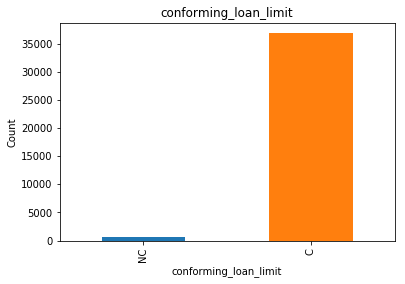

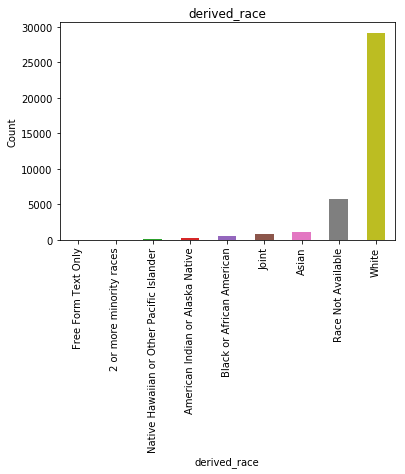

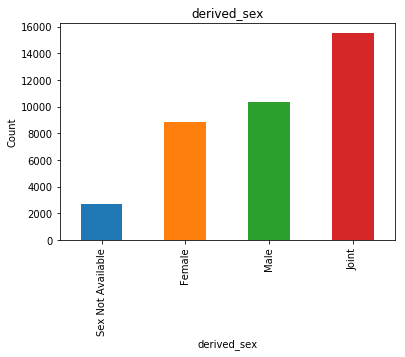

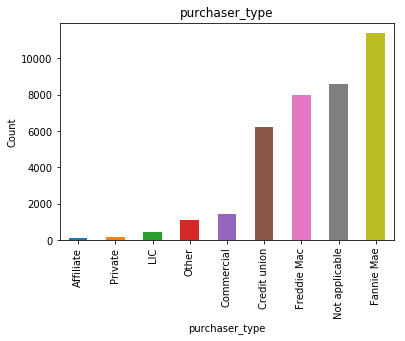

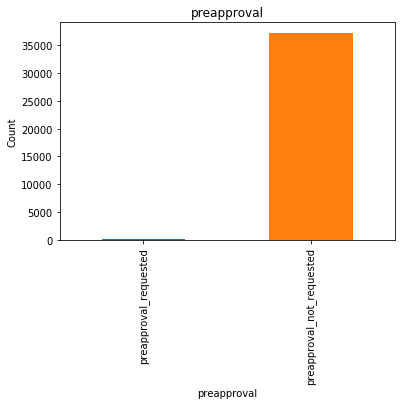

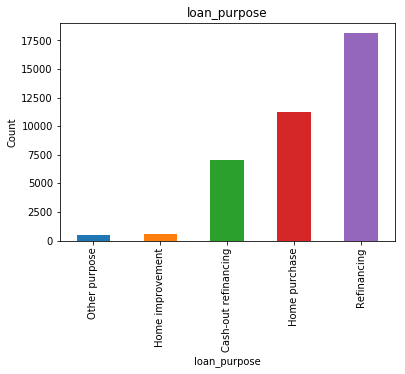

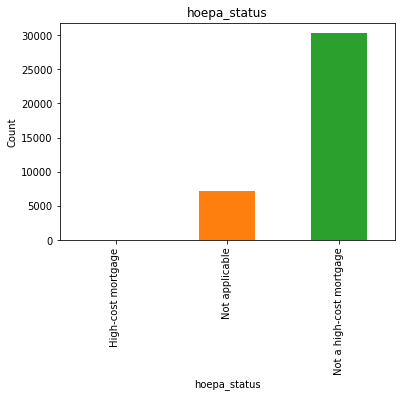

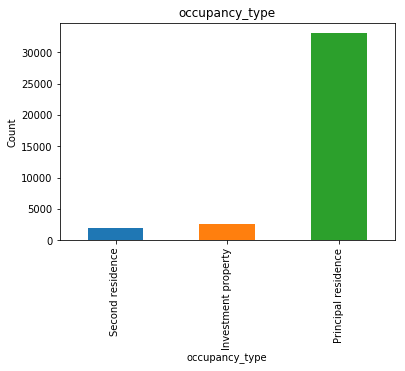

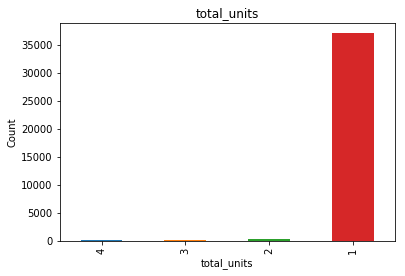

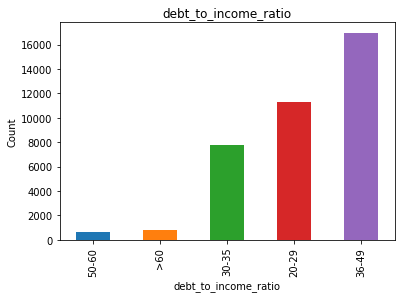

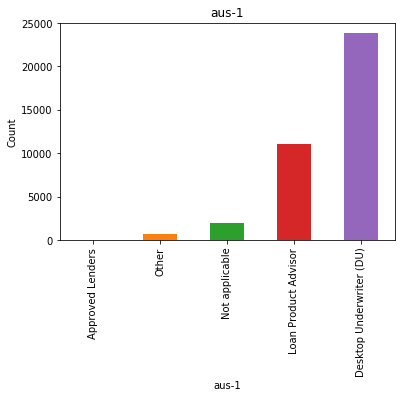

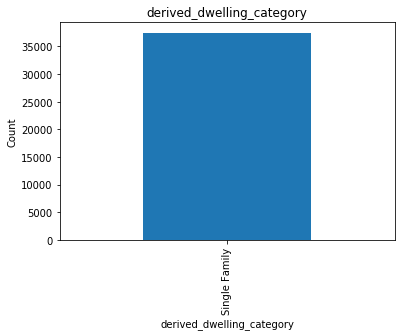

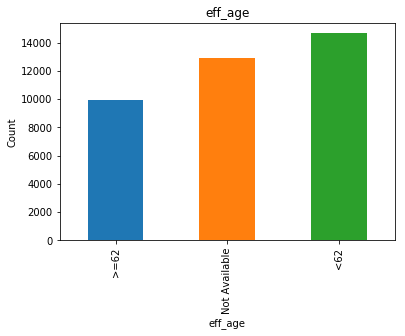

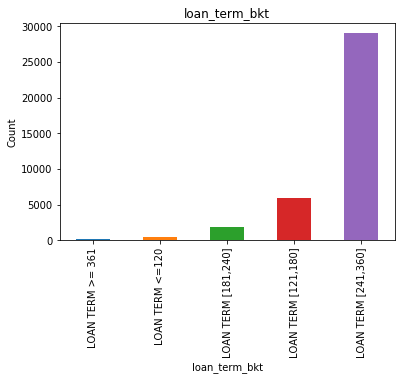

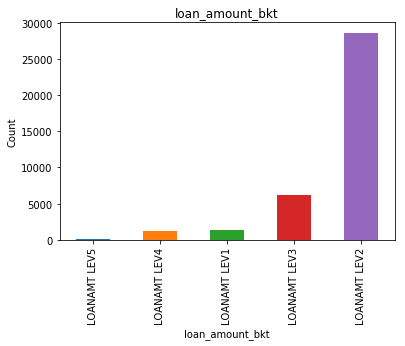

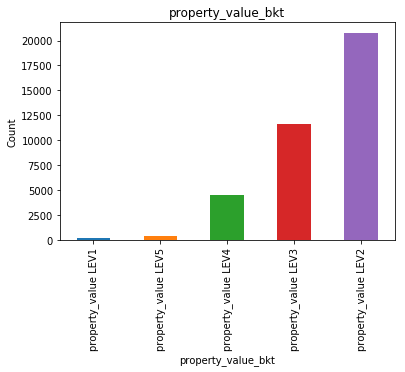

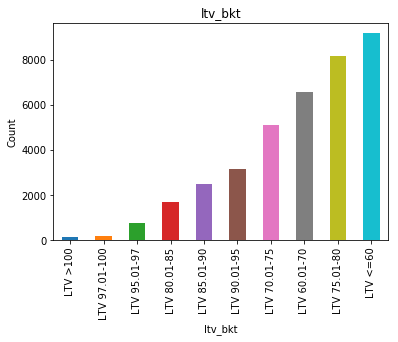

In [24]:
categorical_features=[feature for feature in df_final.columns if df_final[feature].dtypes=='O']
categorical_features
for feature in categorical_features:
    df_final[feature].value_counts().sort_values().plot(kind = 'bar')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count') 
    plt.show()

Looking at the bar plot for all the categorical variables above, we can remove the following features due to same value for most of the records

1. conforming_loan_limit - most values are C
2. preapproval - for most loans pre-approval was not requested
3. total_units - as most values are 1 unit
4. derived_dwelling_category - as all records are single family

Also the categorical variables given below has almost 0 records of a value. Those records can be deleted
1. Hoepa_Status has very low records of High-Cost-Mortgage
2. aus-1 has almost 0 records of Approved Lenders
2. derived_race has almost 0 records of Free Form Text Only

In [25]:
df_final.drop(['conforming_loan_limit','preapproval','total_units','derived_dwelling_category'],axis = 1, inplace = True)

In [26]:
df_final = df_final.loc[df_final['hoepa_status'] != 'High-cost mortgage',:]
df_final = df_final.loc[df_final['aus-1'] != 'Approved Lenders',:]
df_final = df_final.loc[df_final['derived_race'] != 'Free Form Text Only',:]

In [27]:
df_final['hoepa_status'].unique()

array(['Not applicable', 'Not a high-cost mortgage'], dtype=object)

In [28]:
df_final.shape

(37466, 15)

After removing all the rare records and unnecessary fields, we have a total of 43558 fields

### Model Creation

#### One Hot Encoding Categorical Features

In [29]:
df_model = pd.get_dummies(df_final, columns = ['purchaser_type','loan_purpose','hoepa_status','occupancy_type','debt_to_income_ratio','aus-1'
                                               ,'loan_term_bkt','loan_amount_bkt','property_value_bkt'
                                               ,'ltv_bkt','derived_race','derived_sex','eff_age'] ,drop_first=True)

#### Scaling the data

In [30]:
scaler = MinMaxScaler()
df_model_scaled = scaler.fit_transform(df_model)
df_model_scaled = pd.DataFrame(df_model_scaled, columns = df_model.columns)
df_model_scaled.head()

,loan_decision,tract_minority_population_percent,purchaser_type_Commercial,purchaser_type_Credit union,purchaser_type_Fannie Mae,purchaser_type_Freddie Mac,purchaser_type_LIC,purchaser_type_Not applicable,purchaser_type_Other,purchaser_type_Private,loan_purpose_Home improvement,loan_purpose_Home purchase,loan_purpose_Other purpose,loan_purpose_Refinancing,hoepa_status_Not applicable,occupancy_type_Principal residence,occupancy_type_Second residence,debt_to_income_ratio_30-35,debt_to_income_ratio_36-49,debt_to_income_ratio_50-60,debt_to_income_ratio_>60,aus-1_Loan Product Advisor,aus-1_Not applicable,aus-1_Other,loan_term_bkt_LOAN TERM >= 361,"loan_term_bkt_LOAN TERM [121,180]","loan_term_bkt_LOAN TERM [181,240]","loan_term_bkt_LOAN TERM [241,360]",loan_amount_bkt_LOANAMT LEV2,loan_amount_bkt_LOANAMT LEV3,loan_amount_bkt_LOANAMT LEV4,loan_amount_bkt_LOANAMT LEV5,property_value_bkt_property_value LEV2,property_value_bkt_property_value LEV3,property_value_bkt_property_value LEV4,property_value_bkt_property_value LEV5,ltv_bkt_LTV 70.01-75,ltv_bkt_LTV 75.01-80,ltv_bkt_LTV 80.01-85,ltv_bkt_LTV 85.01-90,ltv_bkt_LTV 90.01-95,ltv_bkt_LTV 95.01-97,ltv_bkt_LTV 97.01-100,ltv_bkt_LTV <=60,ltv_bkt_LTV >100,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,eff_age_>=62,eff_age_Not Available
0,1.0,0.471094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.816808,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.237436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.237436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.237436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


#### Checking the Independent Feature

1.0    33696
0.0     3770
Name: loan_decision, dtype: int64

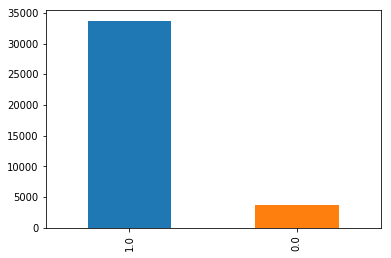

In [31]:
df_model_scaled['loan_decision'].value_counts().plot(kind = 'bar')
df_model_scaled['loan_decision'].value_counts()

The dataset appears to be very biased (imbalanced). So accuracy of the model would not be the only indicator of how good the model functions. We will have to look at precision, recall, AUC score and F1 Score.

#### Model using Statsmodel

In [32]:
y = df_model_scaled['loan_decision']
X = df_model_scaled.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Running Logistic Regression

In [33]:
x_train = sm.add_constant(X_train)
logit_model =sm.Logit(y_train,X_train)
results=logit_model.fit(method='bfgs',maxiter=10000)
stats.chisqprob = lambda chisq, X_train: stats.chi2.sf(chisq, X_train)
print(results.summary())
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()

Optimization terminated successfully.
         Current function value: 0.070628
         Iterations: 427
         Function evaluations: 428
         Gradient evaluations: 428
                           Logit Regression Results                           
Dep. Variable:          loan_decision   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28043
Method:                           MLE   Df Model:                           55
Date:                Sun, 27 Mar 2022   Pseudo R-squ.:                  0.7849
Time:                        21:31:55   Log-Likelihood:                -1984.6
converged:                       True   LL-Null:                       -9226.7
                                        LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

#### Predicting using the model

AUC_Score =  0.9899466000153168
Accuracy =  0.9641293904131526
             precision    recall  f1-score   support

        0.0       0.77      0.92      0.83       918
        1.0       0.99      0.97      0.98      8449

avg / total       0.97      0.96      0.97      9367



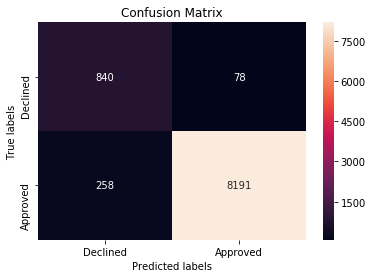

In [34]:
y_pred = results.predict(X_test)
y_true = y_test.values
AUC_Score = roc_auc_score(y_test,y_pred)
print('AUC_Score = ',AUC_Score)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['loan_decision']
y_pred['loan_decision'] = y_pred['loan_decision'].apply(lambda x: 1 if x >0.50000 else 0 )
Accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Declined', 'Approved']); ax.yaxis.set_ticklabels(['Declined', 'Approved']);

precision,recall,fscore,support=score(y_true,y_pred,average='weighted')

#### Exporting the model results

In [35]:
Logit_Output = pd.read_html(results_as_html, header=0, index_col=0)[0]
Logit_Output['Odds_Ratio'] = np.exp(results.params)
Logit_Output['Wald_Chi_Sq'] = (Logit_Output['coef']/Logit_Output['std err'])**2
Logit_Output['R_Squared'] = results.prsquared
Logit_Output['NObsRead'] = len(results.fittedvalues)
Logit_Output['AUC_Score'] = AUC_Score
Logit_Output['Accuracy'] = Accuracy
Logit_Output['Precision'] = precision
Logit_Output['Recall'] = recall
Logit_Output['F1Score'] = fscore
Logit_Output['_ESTTYPE_'] = 'MLE'
Logit_Output['Significance'] = Logit_Output['P>|z|'].apply(lambda x: 'SIGNIFICANT' if x <= 0.05 else 'NOT SIGNIFICANT')
Logit_Output['Analysis_Date'] = datetime.now().strftime("%m-%d-%Y")
Logit_Output['Portfolio'] = 'Convensional First Lien'
Logit_Output['Analysis_Type'] = 'Underwriting'

with pd.ExcelWriter('Model_Results_With_Race_Sex_Age.xlsx') as writer:  
    df_model.to_excel(writer, sheet_name='Raw_Data', index= False)
    Logit_Output.to_excel(writer, sheet_name='Model_Results')

#### Model without Race/Gender/Age field

If we look at the model above, all the indicator variables of purchase_type feature shows very high P-Value. 
So lets experiment removing the purchase_type variable.

Also lets remove the fair lending fields ie Race , Age and Gender fields and see if the model prediction changes its metrics based on just risk factors.

In [36]:
df_model_ref1 = pd.get_dummies(df_final, columns = ['loan_purpose','hoepa_status','occupancy_type','debt_to_income_ratio','aus-1'
                                               ,'loan_term_bkt','loan_amount_bkt','property_value_bkt'
                                               ,'ltv_bkt'] ,drop_first=True)

df_model_ref1.drop(['purchaser_type','derived_race','derived_sex','eff_age','tract_minority_population_percent'], axis = 1 , inplace = True)
scaler = MinMaxScaler()
df_model_ref1_scaled = scaler.fit_transform(df_model_ref1)
df_model_ref1_scaled = pd.DataFrame(df_model_ref1_scaled, columns = df_model_ref1.columns)
df_model_ref1_scaled.head()

y = df_model_ref1_scaled['loan_decision']
X = df_model_ref1_scaled.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
x_train = sm.add_constant(X_train)
logit_model =sm.Logit(y_train,X_train)
results=logit_model.fit(method='bfgs',maxiter=10000)
stats.chisqprob = lambda chisq, X_train: stats.chi2.sf(chisq, X_train)
print(results.summary())
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
y_pred = results.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.088283
         Iterations: 283
         Function evaluations: 284
         Gradient evaluations: 284
                           Logit Regression Results                           
Dep. Variable:          loan_decision   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28064
Method:                           MLE   Df Model:                           34
Date:                Sun, 27 Mar 2022   Pseudo R-squ.:                  0.7311
Time:                        21:33:24   Log-Likelihood:                -2480.7
converged:                       True   LL-Null:                       -9226.7
                                        LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

AUC_Score =  0.9872637723044663
Accuracy =  0.961353688480837
             precision    recall  f1-score   support

        0.0       0.78      0.85      0.81       918
        1.0       0.98      0.97      0.98      8449

avg / total       0.96      0.96      0.96      9367



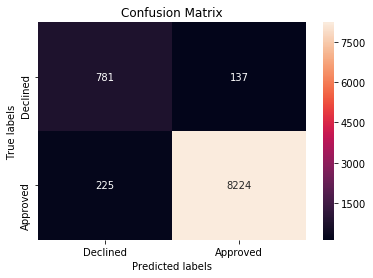

In [37]:
y_pred = results.predict(X_test)
y_true = y_test.values
AUC_Score = roc_auc_score(y_test,y_pred)
print('AUC_Score = ',AUC_Score)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['loan_decision']
y_pred['loan_decision'] = y_pred['loan_decision'].apply(lambda x: 1 if x >0.50000 else 0 )
print('Accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Declined', 'Approved']); ax.yaxis.set_ticklabels(['Declined', 'Approved']);
precision,recall,fscore,support=score(y_true,y_pred,average='weighted')

No significant change in accuracy but we see a drop in precision and recall value of the model. 

#### Exporting to Excel

In [38]:
Logit_Output = pd.read_html(results_as_html, header=0, index_col=0)[0]
Logit_Output['Odds_Ratio'] = np.exp(results.params)
Logit_Output['Wald_Chi_Sq'] = (Logit_Output['coef']/Logit_Output['std err'])**2
Logit_Output['R_Squared'] = results.prsquared
Logit_Output['NObsRead'] = len(results.fittedvalues)
Logit_Output['AUC_Score'] = AUC_Score
Logit_Output['Accuracy'] = Accuracy
Logit_Output['Precision'] = precision
Logit_Output['Recall'] = recall
Logit_Output['F1Score'] = fscore
Logit_Output['_ESTTYPE_'] = 'MLE'
Logit_Output['Significance'] = Logit_Output['P>|z|'].apply(lambda x: 'SIGNIFICANT' if x <= 0.05 else 'NOT SIGNIFICANT')
Logit_Output['Analysis_Date'] = datetime.now().strftime("%m-%d-%Y")
Logit_Output['Portfolio'] = 'Convensional First Lien'
Logit_Output['Analysis_Type'] = 'Underwriting'

with pd.ExcelWriter('Model_Results_Without_Race_Sex_Age.xlsx') as writer:  
    df_model.to_excel(writer, sheet_name='Raw_Data', index= False)
    Logit_Output.to_excel(writer, sheet_name='Model_Results')



### Time taken to run the model

In [39]:
elapsed_time = (time.time() - start_time)/60
print ('Time taken to run this code {} mins' .format(elapsed_time))

Time taken to run this code 3.298060103257497 mins
